# Estrazione delle quadruple (aspect-opinion-category-sentiment) con ModernBERT su Restaurant-ACOS

In [3]:
# Import delle librerie necessarie
import torch
import numpy as np
import random
import pandas as pd
import wandb
import os
import sys
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
import bitsandbytes as bnb
import pickle

from evaluate import load
from tqdm import tqdm

from torch.amp import autocast, GradScaler # Per Mixed Precision

print("Librerie caricate.")

Librerie caricate.


### Impostazioni per la riproducibilità 

In [2]:
def set_seed(seed_value=42):
    """Imposto i seed per la riproducibilità."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        # Imposto anche i seed per la GPU, se disponibile
        torch.cuda.manual_seed_all(seed_value)

# Esegui l'impostazione del seed
set_seed(42) 
print("Random seeds impostati su 42.")

Random seeds impostati su 42.


In [4]:
import wandb

WANDB_ENTITY = "cristinatextmining"

# 1. Definizione degli Hyperparameters
config = {
    "learning_rate": 5e-5,
    "epochs": 10,
    "batch_size": 16,
    "model_name": "answerdotai/ModernBERT-base",
    "dataset": "Restaurant-ACOS",  
    "seed": 42,
    'patience': 2  # Per Early Stopping
}

# 2. Inizializzazione del Run
wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    config=config,
    name=f"run_{config['model_name']}_{config['dataset']}"
)

print(f"W&B inizializzato per il progetto: {wandb.run.project}")
print(f"Nome della Run attuale: {wandb.run.name}")

wandb: Currently logged in as: cristinatomaciello2001 (cristinatextmining) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B inizializzato per il progetto: BigData-TextMining-ACOS
Nome della Run attuale: run_answerdotai/ModernBERT-base_Restaurant-ACOS


## PyTorch Dataset & DataLoader Construction

### Creazione di PyTorch Dataset e DataLoader
In questa fase, trasformiamo i nostri DataFrame Pandas (strutture dati tabellari) in oggetti Dataset e DataLoader di PyTorch. Questo passaggio è il "ponte" necessario per alimentare il modello ModernBERT durante l'addestramento.

#### Obiettivi di questa sezione:

  1. Standardizzazione dei Dati (ACOSDataset):

       * I modelli basati su Transformer non possono leggere direttamente i DataFrame. La classe ACOSDataset estrae le liste di input_ids, attention_mask e labels e le converte in Tensori PyTorch (torch.tensor).

       * Viene utilizzato il tipo di dato torch.long, richiesto dai layer di embedding e dalle funzioni di calcolo della Loss per task di classificazione.

  2. Gestione del Caricamento (DataLoader):

      * Batching: Invece di caricare l'intero dataset in memoria (rischioso per la GPU), i dati vengono divisi in piccoli blocchi chiamati Batch (nel nostro caso di dimensione 16).

      * Shuffling (Solo Training): Utilizziamo shuffle=True nel train_loader per rimescolare l'ordine delle frasi a ogni epoca. Questo impedisce al modello di imparare l'ordine sequenziale dei dati, costringendolo invece a focalizzarsi sui pattern linguistici reali.

      * Efficienza: I DataLoader gestiscono il caricamento dei dati in parallelo, ottimizzando i tempi di addestramento sulla GPU.

In [9]:

# --- 1. CARICAMENTO DEI DATASET SALVATI  ---
cartella_dati = "data_allineati"

print("📂 Caricamento dei dataset pre-processati...")
# Carichiamo i Ristoranti
df_train_align_rest = pd.read_pickle(os.path.join(cartella_dati, "train_rest_aligned.pkl"))
df_dev_align_rest = pd.read_pickle(os.path.join(cartella_dati, "dev_rest_aligned.pkl"))
df_test_align_rest = pd.read_pickle(os.path.join(cartella_dati, "test_rest_aligned.pkl"))


class ACOSDataset(Dataset):
    def __init__(self, df):
        # Estraiamo le colonne che abbiamo generato nella fase di allineamento
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.labels = df['labels'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        # Convertiamo le liste in Tensori di PyTorch (LongTensor per ID e Label)
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# --- CREAZIONE DELLE ISTANZE ---

# Creiamo i dataset per il dominio restaruant
train_dataset_rest = ACOSDataset(df_train_align_rest)
dev_dataset_rest = ACOSDataset(df_dev_align_rest)
test_dataset_rest = ACOSDataset(df_test_align_rest)

# --- CONFIGURAZIONE DATALOADERS ---

BATCH_SIZE = 16 # Numero di frasi analizzate contemporaneamente

train_loader_rest = DataLoader(train_dataset_rest, batch_size=BATCH_SIZE, shuffle=True)
dev_loader_rest = DataLoader(dev_dataset_rest, batch_size=BATCH_SIZE)
test_loader_rest = DataLoader(test_dataset_rest, batch_size=BATCH_SIZE)

print(f"Dataset e DataLoaders creati con successo!")
print(f"Esempi nel set di Training RESTAURANT: {len(train_dataset_rest)}")  

📂 Caricamento dei dataset pre-processati...
Dataset e DataLoaders creati con successo!
Esempi nel set di Training RESTAURANT: 1530


### Definizione e l'Inizializzazione del Modello di Token Classification.

1. Caricare il "Cervello" (ModernBERT Pre-trained)
Dobbiamo scaricare il modello ModernBERT-base dal repository di Hugging Face. In questa fase, il modello sa già "leggere" e "capire" la lingua inglese perché è stato addestrato su miliardi di testi, ma non sa ancora nulla del tuo task specifico (ACOS). È come un laureato in lingue che però non ha mai lavorato in un ristorante o in un negozio di computer.

2. Aggiungere la "Testa" di Classificazione
ModernBERT normalmente restituisce dei vettori numerici (embedding) per ogni parola. Noi dobbiamo aggiungere sopra questi vettori uno strato finale chiamato Linear Layer (o testa di classificazione).

   * Questo strato prenderà l'output di ModernBERT e lo "schiaccerà" su 5 classi possibili: 0 (O), 1 (B-ASP), 2 (I-ASP), 3 (B-OPI), 4 (I-OPI).

   * Il modello dovrà imparare a mappare ogni pezzetto di frase a una di queste cinque etichette.

3. Configurare la Strategia di Apprendimento (Optimizer & Loss)
Dobbiamo dare al modello gli strumenti per imparare dai suoi errori:

  * Loss Function (Funzione di Perdita): Useremo la CrossEntropyLoss. È il "voto" che diamo al modello. Se il modello dice che "pizza" è un'opinione (B-OPI) ma il tuo dataset dice che è un aspetto (B-ASP), la Loss sarà alta. Il modello cercherà di abbassarla il più possibile.

   * Optimizer (Ottimizzatore): Di solito si usa AdamW. È l'algoritmo che decide "come" e "quanto" cambiare i pesi interni del modello per correggere gli errori.

   * Learning Rate: La velocità con cui il modello impara. Se è troppo alta, il modello è "frettoloso" e sbaglia; se è troppo bassa, non imparerà mai.

In [10]:

# --- 1. CONFIGURAZIONE DEL DEVICE ---
# Se hai una GPU NVIDIA, userà 'cuda'. Se hai un Mac M1/M2, userà 'mps'. Altrimenti 'cpu'.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f" GPU Trovata: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Acceleratore Apple Metal (MPS) Trovato")
else:
    device = torch.device("cpu")
    print(" Nessuna GPU trovata. L'addestramento sarà lento.")

# --- 2. CARICAMENTO DI MODERNBERT (IL "CERVELLO") + TESTA DI CLASSIFICAZIONE ---
# Definiamo le 5 etichette: 0=O, 1=B-ASP, 2=I-ASP, 3=B-OPI, 4=I-OPI
NUM_LABELS = 5 

print("Scaricamento e configurazione di ModernBERT...")
model = AutoModelForTokenClassification.from_pretrained(
    "answerdotai/ModernBERT-base",
    num_labels=NUM_LABELS
)

# Spostiamo il modello sul dispositivo di calcolo (GPU/MPS/CPU)
model.to(device)

# --- 3. CONFIGURAZIONE DELL'OTTIMIZZATORE E DELLA LOSS ---



# A. Optimizer (AdamW 8-bit)
# Usiamo il Learning Rate standard di 5e-5 come definito nei parametri sperimentali 
# e la versione a 8-bit per non saturare la memoria
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=5e-5)

# B. Loss Function (CrossEntropyLoss)
# La funzione che calcola l'errore tra la predizione del modello e le label reali.
# Nota: 'ignore_index=-100' è lo standard di PyTorch per ignorare i token di padding nel calcolo dell'errore.
loss_fn = nn.CrossEntropyLoss()

print("\n" + "="*50)
print("MODELLO PRONTO PER IL TRAINING")
print("="*50)
print(f"Architettura: ModernBERT-base")
print(f"Task: Token Classification (Estrazione Aspetti & Opinioni)")
print(f"Numero di Classi: {NUM_LABELS}")
print(f"Optimizer: AdamW 8-bit (lr=5e-5)")
print(f"Loss Function: CrossEntropyLoss")

 GPU Trovata: NVIDIA GeForce RTX 4050 Laptop GPU
Scaricamento e configurazione di ModernBERT...


Loading weights:   0%|          | 0/136 [00:00<?, ?it/s]

ModernBertForTokenClassification LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     | 
------------------+------------+-
decoder.bias      | UNEXPECTED | 
classifier.weight | MISSING    | 
classifier.bias   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



MODELLO PRONTO PER IL TRAINING
Architettura: ModernBERT-base
Task: Token Classification (Estrazione Aspetti & Opinioni)
Numero di Classi: 5
Optimizer: AdamW 8-bit (lr=5e-5)
Loss Function: CrossEntropyLoss


In [11]:
# --- 1. CONFIGURAZIONE AVANZATA MEMORIA ---
# Gradient Checkpointing: risparmia tantissima VRAM ricalcolando i passaggi intermedi
model.gradient_checkpointing_enable()

# Parametri per simulare un batch size maggiore
accumulation_steps = config.get('accumulation_steps', 4) 
patience = config.get('patience', 2)
patience_counter = 0

optimizer = bnb.optim.AdamW8bit(
    model.parameters(), 
    lr=config['learning_rate']
)
# Scaler per Mixed Precision (fondamentale per evitare l'OOM)
scaler = GradScaler() 

total_steps = (len(train_loader_rest) // accumulation_steps) * config['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# --- 2. FUNZIONI DI SUPPORTO OTTIMIZZATE ---

def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Usiamo autocast anche in valutazione
            with autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            total_loss += outputs.loss.item()
    return total_loss / len(data_loader)

def train_epoch(model, data_loader, optimizer, scheduler, device, epoch_idx, scaler, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad() # Reset iniziale
    
    loop = tqdm(data_loader, leave=True)
    
    for i, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # A. Mixed Precision Forward Pass
        with autocast(device_type='cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps 
        
        # B. Backward Pass con Scaler
        scaler.scale(loss).backward()
        
        # C. Update Pesi ogni 'accumulation_steps'
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        wandb.log({"batch_loss": loss.item() * accumulation_steps})
        loop.set_description(f"Epoca {epoch_idx + 1}")
        loop.set_postfix(loss=loss.item() * accumulation_steps)

    return total_loss / len(data_loader)

# --- 3. CICLO DI ADDESTRAMENTO ---

print(f"🚀 Training su RESTAURANT: {config['epochs']} epoche | Device: {device}")
print(f"📦 Accumulo Gradienti ogni {accumulation_steps} step | FP16 Attivato")

best_valid_loss_rest = float('inf')


for epoch in range(config['epochs']):
    print(f"\n--- Epoca {epoch+1}/{config['epochs']} ---")
    
    # 1. Training
    train_loss_rest = train_epoch(model, train_loader_rest, optimizer, scheduler, device, epoch, scaler, accumulation_steps)
    
    # 2. Validazione
    valid_loss_rest = evaluate_model(model, dev_loader_rest, device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"📉 Train Loss: {train_loss_rest:.4f} | 🔍 Valid Loss: {valid_loss_rest:.4f}")
    
    # 3. Log metriche epoca su W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss_epoch": train_loss_rest,
        "valid_loss_epoch": valid_loss_rest
    })
    
    # --- LOGICA EARLY STOPPING & CHECKPOINT ---
    
    # Se il modello migliora (la valid loss scende)
    if valid_loss_rest < best_valid_loss_rest:
        best_valid_loss_rest = valid_loss_rest
        patience_counter = 0  # ### NUOVO: Resettiamo la pazienza ###
        
        print(f"💾 Miglior modello trovato (Loss: {best_valid_loss_rest:.4f})! Salvataggio...")
        

        # Creiamo la cartella se non esiste (sicurezza aggiuntiva)
        if not os.path.exists("./best_model_restaurant"):
            os.makedirs("./best_model_restaurant")
            
        model.save_pretrained("./best_model_restaurant")
        
    # Se il modello NON migliora
    else:
        patience_counter += 1  # ### NUOVO: Incrementiamo il contatore ###
        print(f"⚠️ Nessun miglioramento. Patience: {patience_counter}/{patience}")
        
        # Se abbiamo esaurito la pazienza
        if patience_counter >= patience:
            print(f"\n🛑 EARLY STOPPING ATTIVATO! Interruzione all'epoca {epoch+1}.")
            break # Esce dal ciclo for

print("\n✅ Fine Addestramento.")
wandb.finish()

🚀 Training su RESTAURANT: 10 epoche | Device: cuda
📦 Accumulo Gradienti ogni 4 step | FP16 Attivato

--- Epoca 1/10 ---


  0%|          | 0/96 [00:00<?, ?it/s]

Epoca 1: 100%|██████████| 96/96 [00:19<00:00,  4.87it/s, loss=0.0938]


📉 Train Loss: 0.2205 | 🔍 Valid Loss: 0.0974
💾 Miglior modello trovato (Loss: 0.0974)! Salvataggio...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoca 2/10 ---


Epoca 2: 100%|██████████| 96/96 [00:19<00:00,  4.90it/s, loss=0.0757]


📉 Train Loss: 0.0855 | 🔍 Valid Loss: 0.0581
💾 Miglior modello trovato (Loss: 0.0581)! Salvataggio...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoca 3/10 ---


Epoca 3: 100%|██████████| 96/96 [00:19<00:00,  4.98it/s, loss=0.0501]


📉 Train Loss: 0.0536 | 🔍 Valid Loss: 0.0414
💾 Miglior modello trovato (Loss: 0.0414)! Salvataggio...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoca 4/10 ---


Epoca 4: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s, loss=0.0604]


📉 Train Loss: 0.0363 | 🔍 Valid Loss: 0.0410
💾 Miglior modello trovato (Loss: 0.0410)! Salvataggio...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoca 5/10 ---


Epoca 5: 100%|██████████| 96/96 [00:19<00:00,  5.00it/s, loss=0.0217] 


📉 Train Loss: 0.0249 | 🔍 Valid Loss: 0.0394
💾 Miglior modello trovato (Loss: 0.0394)! Salvataggio...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoca 6/10 ---


Epoca 6: 100%|██████████| 96/96 [00:19<00:00,  4.87it/s, loss=0.0219] 


📉 Train Loss: 0.0160 | 🔍 Valid Loss: 0.0426
⚠️ Nessun miglioramento. Patience: 1/2

--- Epoca 7/10 ---


Epoca 7: 100%|██████████| 96/96 [00:19<00:00,  4.86it/s, loss=0.00836]


📉 Train Loss: 0.0096 | 🔍 Valid Loss: 0.0464
⚠️ Nessun miglioramento. Patience: 2/2

🛑 EARLY STOPPING ATTIVATO! Interruzione all'epoca 7.

✅ Fine Addestramento.


batch_loss,█▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▅▆▇█
train_loss_epoch,█▄▂▂▂▁▁
valid_loss_epoch,█▃▁▁▁▁▂
batch_loss,0.00836
epoch,7
train_loss_epoch,0.00963
valid_loss_epoch,0.04638


In [12]:

# --- A. CARICAMENTO DEL "CAMPIONE" ---
# Carichiamo i pesi migliori salvati durante il training (Epoca 3)
print("📂 Caricamento del modello migliore...")
model_path = "./best_model_restaurant"
model = AutoModelForTokenClassification.from_pretrained(model_path)
model.to(device)
model.eval() # Modalità esame (spegne dropout)

# --- B. PREPARAZIONE METRICHE ---
# Carichiamo la metrica seqeval (standard per NER/ABSA)
metric = load("seqeval")

# Mappa per decodificare i numeri in etichette
# (Assicurati che corrisponda al tuo training!)
id2label = {0: 'O', 1: 'B-ASP', 2: 'I-ASP', 3: 'B-OPI', 4: 'I-OPI'}
label_list = list(id2label.values())

print("🚀 Inizio Test sul Dataset Restaurant...")

# --- C. CICLO DI PREVISIONE ---
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader_rest, desc="Test RESTAURANT"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 1. Il modello predice
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # 2. Prendiamo la classe con probabilità più alta (argmax)
        preds = torch.argmax(logits, dim=-1)

        # 3. Convertiamo i numeri in etichette (pulendo i -100)
        # Dobbiamo ignorare i token speciali (-100) usati per il padding/subwords
        for i in range(len(labels)):
            true_label_row = []
            pred_label_row = []
            
            for j in range(len(labels[i])):
                if labels[i][j] != -100: # Ignoriamo i token di padding/speciali
                    true_label_row.append(id2label[labels[i][j].item()])
                    pred_label_row.append(id2label[preds[i][j].item()])
            
            true_labels.append(true_label_row)
            predictions.append(pred_label_row)

# --- D. CALCOLO E STAMPA RISULTATI ---
results = metric.compute(predictions=predictions, references=true_labels)

print("\n" + "="*50)
print("📊 RISULTATI FINALI (TEST SET - RESTAURANT)")
print("="*50)

# Stampiamo le metriche generali
print(f"Overall Precision: {results['overall_precision']:.4f}")
print(f"Overall Recall:    {results['overall_recall']:.4f}")
print(f"Overall F1-Score:  {results['overall_f1']:.4f}")
print(f"Overall Accuracy:  {results['overall_accuracy']:.4f}")

print("\n🔍 Dettaglio per Classe (Quello che conta per il paper):")
print("-" * 50)
# Estraiamo le metriche specifiche per ASP e OPI
for key in results.keys():
    if key in ['ASP', 'OPI']: # Filtriamo solo le nostre classi di interesse
        print(f"🔹 {key}:")
        print(f"   Precision: {results[key]['precision']:.4f}")
        print(f"   Recall:    {results[key]['recall']:.4f}")
        print(f"   F1-Score:  {results[key]['f1']:.4f}")
        print(f"   Support:   {results[key]['number']}") # Quanti ce n'erano davvero
print("="*50)

📂 Caricamento del modello migliore...


Loading weights:   0%|          | 0/138 [00:00<?, ?it/s]

🚀 Inizio Test sul Dataset Restaurant...


Test RESTAURANT: 100%|██████████| 37/37 [00:06<00:00,  5.49it/s]



📊 RISULTATI FINALI (TEST SET - RESTAURANT)
Overall Precision: 0.6832
Overall Recall:    0.7110
Overall F1-Score:  0.6968
Overall Accuracy:  0.9824

🔍 Dettaglio per Classe (Quello che conta per il paper):
--------------------------------------------------
🔹 ASP:
   Precision: 0.6384
   Recall:    0.6447
   F1-Score:  0.6416
   Support:   608
🔹 OPI:
   Precision: 0.7229
   Recall:    0.7731
   F1-Score:  0.7472
   Support:   648


## Classificatore Category-Sentiment (Extract-Classify-ACOS)

Implementiamo il **secondo stadio** dell'architettura proposta nel paper. Dopo aver estratto gli Aspetti e le Opinioni nello Step 1, ora dobbiamo capire a quale Categoria appartengono e qual è il loro Sentiment.

Il codice di preparazione è diviso in tre componenti fondamentali:

 1. Il Dataset PyTorch (`ACOSPairDataset`)

 2. L'Architettura Custom (`ModernBertACOSClassifier`)

 3. Inizializzazione e DataLoaders

### 1. Il Dataset PyTorch (`ACOSPairDataset`)
Questa classe si occupa di "impacchettare" i dati per la rete neurale. 
Legge le coppie salvate nei file `.pkl`, passa il testo nel Tokenizer di ModernBERT e trasforma tutto in **Tensori PyTorch**. Nota chiave: legge direttamente gli indici degli span (che ho già corretto con l'offset `+1` per far spazio al token `[CLS]`) e carica l'array di 121 etichette (le "soluzioni").

In [3]:

class ACOSPairDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['review_text']
        
        # Gli span sono già corretti con il +1 per il [CLS]!
        a_span = row['aspect_span']
        o_span = row['opinion_span']

        # Tokenizzazione (ModernBERT usa il token [CLS] in automatico)
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        labels = torch.tensor(row['labels'], dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'aspect_span': torch.tensor(a_span),
            'opinion_span': torch.tensor(o_span),
            'labels': labels
        }

### 2. L'Architettura Custom (`ModernBertACOSClassifier`)
Questa è la vera "magia" matematica del paper, tradotta in codice:
* **Il Corpo (Backbone):** Invece di partire da zero, carichiamo il *corpo* del modello che hai già addestrato nello Step 1 (`best_model_laptop`). In questo modo, la rete conosce già il dominio tecnico dei computer!
* **Span Pooling:** Il modello estrae i vettori (hidden states) corrispondenti alle parole dell'Aspetto e dell'Opinione e ne calcola la media. Se un elemento è implicito (`-1`), pesca automaticamente il vettore globale del token `[CLS]`.
* **Feature Fusion:** Concatena il vettore dell'aspetto ($u_a$) e dell'opinione ($u_o$) in un unico grande vettore di dimensione 1536.
* **Le 121 Teste (Multiple Multi-class):** Passa questo vettore in 121 classificatori lineari paralleli. Ognuno di essi deciderà se per la *sua* categoria la coppia è `Positive (0)`, `Negative (1)`, `Neutral (2)` o `Invalid (3)`.

In [4]:
import torch.nn as nn
from transformers import AutoModel

class ModernBertACOSClassifier(nn.Module):
    def __init__(self, path_to_best_model, num_categories):
        super(ModernBertACOSClassifier, self).__init__()
        
        # Carichiamo SOLO IL CORPO dal tuo modello dello Step 1
        self.modernbert = AutoModel.from_pretrained(path_to_best_model)
        hidden_size = self.modernbert.config.hidden_size # 768
        
        # Le 121 teste (ognuna prende il vettore concatenato 1536 e sputa 4 classi)
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size * 2, 4) for _ in range(num_categories)
        ])
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, aspect_spans, opinion_spans):
        outputs = self.modernbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state # [Batch, Seq_Len, 768]
        
        batch_size = last_hidden_state.size(0)
        u_a_list, u_o_list = [], []

        for i in range(batch_size):
            # Pooling Aspetto
            a_start, a_end = aspect_spans[i]
            if a_start == -1: 
                u_a = last_hidden_state[i, 0, :] # Token [CLS]
            else:
                u_a = last_hidden_state[i, a_start:a_end, :].mean(dim=0)
            
            # Pooling Opinione
            o_start, o_end = opinion_spans[i]
            if o_start == -1: 
                u_o = last_hidden_state[i, 0, :] # Token [CLS]
            else:
                u_o = last_hidden_state[i, o_start:o_end, :].mean(dim=0)
            
            u_a_list.append(u_a)
            u_o_list.append(u_o)

        # Concatenazione: [u_a ; u_o]
        combined_features = torch.cat((torch.stack(u_a_list), torch.stack(u_o_list)), dim=-1)
        combined_features = self.dropout(combined_features)

        # Passiamo il vettore nelle teste lineari
        logits = [head(combined_features) for head in self.heads]
        
        # Output: [Batch, 121, 4]
        return torch.stack(logits, dim=1)

### 3. Inizializzazione e DataLoaders
L'ultimo blocco carica fisicamente i file salvati dalla nostra "Fabbrica dei Dati", istanzia i `Dataset`, e crea i `DataLoader` (con batch size = 16) per "nutrire" la GPU in modo efficiente durante l'addestramento. Infine, sposta il modello sulla scheda video (CUDA) pronto per il training.

In [5]:

# 1. Carichiamo la lista delle categorie salvata prima
with open("data_coppie/restaurant_categories.pkl", "rb") as f:
    category_list = pickle.load(f)
num_categories = len(category_list) # 121

# 2. Carichiamo i DataFrame di Train e Dev
df_train = pd.read_pickle("data_coppie/train_restaurant_pairs.pkl")
df_dev = pd.read_pickle("data_coppie/dev_restaurant_pairs.pkl")
df_test = pd.read_pickle("data_coppie/test_restaurant_pairs.pkl")

# 3. Inizializziamo il Tokenizer e i Dataset
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_dataset = ACOSPairDataset(df_train, tokenizer)
dev_dataset = ACOSPairDataset(df_dev, tokenizer)
test_dataset = ACOSPairDataset(df_test, tokenizer) 

# 4. Creiamo i DataLoader (Batch size 16 è un buon compromesso tra velocità e VRAM)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16) 
# 5. Inizializziamo il Modello usando i pesi dello Step 1!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModernBertACOSClassifier("./best_model_restaurant", num_categories)
model.to(device)

print(f"Modello inizializzato! Categorie: {num_categories} | Device: {device}")

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: ./best_model_restaurant
Key               | Status     |  | 
------------------+------------+--+-
classifier.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 
classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Modello inizializzato! Categorie: 13 | Device: cuda


## WANDB per lo step 2

In [6]:

# Chiudiamo per sicurezza qualsiasi run precedente rimasta aperta nello stesso notebook
if wandb.run is not None:
    wandb.finish()

WANDB_ENTITY = "cristinatextmining"

# 1. Definizione degli Hyperparameters per lo STEP 2
config_step2 = {
    "learning_rate": 2e-5, # Solitamente per lo Step 2 un LR leggermente più basso è meglio (es. 2e-5)
    "epochs": 40,
    "batch_size": 16,
    "accumulation_steps": 4, # Aggiunto per il tuo training loop ottimizzato!
    "model_name": "answerdotai/ModernBERT-base",
    "dataset": "Restaurant-ACOS", 
    "seed": 42,
    "patience": 2  # Per Early Stopping
}

# 2. Inizializzazione del Run per lo Step 2
wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    config=config_step2,
    # Aggiungiamo "Step2_Class" al nome per distinguerlo dallo Step 1
    name=f"Step2_Class_{config_step2['model_name']}_{config_step2['dataset']}" 
)

print(f" W&B inizializzato per il progetto: {wandb.run.project}")
print(f"Nome della Run attuale: {wandb.run.name}")

wandb: Currently logged in as: cristinatomaciello2001 (cristinatextmining) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 W&B inizializzato per il progetto: BigData-TextMining-ACOS
Nome della Run attuale: Step2_Class_answerdotai/ModernBERT-base_Restaurant-ACOS


## Train su Sentiment e Categoria

In [7]:
import os
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
import bitsandbytes as bnb
from tqdm import tqdm
import wandb

# --- 1. CONFIGURAZIONE AVANZATA MEMORIA ---

# Gradient Checkpointing: abilitato SOLO sul corpo di ModernBERT
model.modernbert.gradient_checkpointing_enable()

# Parametri per simulare un batch size maggiore
accumulation_steps = config_step2.get('accumulation_steps', 4) 
patience = config_step2.get('patience', 2)
patience_counter = 0

# Ottimizzatore AdamW a 8-bit
optimizer = bnb.optim.AdamW8bit(
    model.parameters(), 
    lr=config_step2['learning_rate']
)

# Scaler per Mixed Precision (fondamentale per evitare l'OOM)
scaler = GradScaler() 

# La Loss pesata per contrastare lo sbilanciamento delle classi
weights = torch.tensor([150.0, 400.0, 100.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Calcolo degli step totali per lo scheduler
total_steps = (len(train_loader) // accumulation_steps) * config_step2['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# --- 2. FUNZIONI DI SUPPORTO OTTIMIZZATE (STEP 2) ---

def evaluate_model_step2(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            aspect_span = batch['aspect_span'].to(device)
            opinion_span = batch['opinion_span'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type='cuda'):
                logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                               aspect_spans=aspect_span, opinion_spans=opinion_span)
                
                loss = criterion(logits.view(-1, 4), labels.view(-1))
            
            total_loss += loss.item()
            
    return total_loss / len(data_loader)

def train_epoch_step2(model, data_loader, optimizer, scheduler, criterion, device, epoch_idx, scaler, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad() 
    
    loop = tqdm(data_loader, leave=True)
    
    for i, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        aspect_span = batch['aspect_span'].to(device)
        opinion_span = batch['opinion_span'].to(device)
        labels = batch['labels'].to(device)
        
        with autocast(device_type='cuda'):
            logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                           aspect_spans=aspect_span, opinion_spans=opinion_span)
            
            loss = criterion(logits.view(-1, 4), labels.view(-1))
            loss = loss / accumulation_steps 
        
        scaler.scale(loss).backward()
        
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        real_loss = loss.item() * accumulation_steps
        total_loss += real_loss
        
        wandb.log({"batch_loss": real_loss})
        loop.set_description(f"Epoca {epoch_idx + 1}")
        loop.set_postfix(loss=real_loss)

    return total_loss / len(data_loader)

# --- 3. CICLO DI ADDESTRAMENTO ---

print(f"Training STEP 2 su RESTAURANT: {config_step2['epochs']} epoche | Device: {device}")
print(f"Accumulo Gradienti ogni {accumulation_steps} step | FP16 Attivato")

best_valid_loss_restaurant = float('inf')

for epoch in range(config_step2['epochs']):
    print(f"\n--- Epoca {epoch+1}/{config_step2['epochs']} ---")
    
    # 1. Training
    train_loss_restaurant = train_epoch_step2(
        model, train_loader, optimizer, scheduler, criterion, 
        device, epoch, scaler, accumulation_steps
    )
    
    # 2. Validazione
    valid_loss_restaurant = evaluate_model_step2(model, val_loader, criterion, device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Train Loss: {train_loss_restaurant:.4f} | Valid Loss: {valid_loss_restaurant:.4f}")
    
    # 3. Log metriche epoca su W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss_epoch": train_loss_restaurant,
        "valid_loss_epoch": valid_loss_restaurant
    })
    
    # --- LOGICA EARLY STOPPING & CHECKPOINT ---
    
    if valid_loss_restaurant < best_valid_loss_restaurant:
        best_valid_loss_restaurant = valid_loss_restaurant
        patience_counter = 0  
        
        print(f"Miglior modello trovato (Loss: {best_valid_loss_restaurant:.4f})! Salvataggio...")
        
        # Salvataggio custom model nella cartella dei RESTAURANT
        save_dir = "./best_classifier_restaurant"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
        
    else:
        patience_counter += 1  
        print(f"Nessun miglioramento. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\nEARLY STOPPING ATTIVATO! Interruzione all'epoca {epoch+1}.")
            break 

print("\nFine Addestramento Step 2 (Restaurant).")
wandb.finish()

Training STEP 2 su RESTAURANT: 40 epoche | Device: cuda
Accumulo Gradienti ogni 4 step | FP16 Attivato

--- Epoca 1/40 ---


Epoca 1: 100%|██████████| 232/232 [00:49<00:00,  4.71it/s, loss=0.567]


Train Loss: 1.1117 | Valid Loss: 0.8788
Miglior modello trovato (Loss: 0.8788)! Salvataggio...

--- Epoca 2/40 ---


Epoca 2: 100%|██████████| 232/232 [00:48<00:00,  4.82it/s, loss=1.46] 


Train Loss: 0.7352 | Valid Loss: 0.7438
Miglior modello trovato (Loss: 0.7438)! Salvataggio...

--- Epoca 3/40 ---


Epoca 3: 100%|██████████| 232/232 [00:50<00:00,  4.56it/s, loss=1.31] 


Train Loss: 0.5610 | Valid Loss: 0.6204
Miglior modello trovato (Loss: 0.6204)! Salvataggio...

--- Epoca 4/40 ---


Epoca 4: 100%|██████████| 232/232 [00:51<00:00,  4.55it/s, loss=0.843]


Train Loss: 0.4305 | Valid Loss: 0.6102
Miglior modello trovato (Loss: 0.6102)! Salvataggio...

--- Epoca 5/40 ---


Epoca 5: 100%|██████████| 232/232 [00:50<00:00,  4.58it/s, loss=0.193]


Train Loss: 0.3276 | Valid Loss: 0.6053
Miglior modello trovato (Loss: 0.6053)! Salvataggio...

--- Epoca 6/40 ---


Epoca 6: 100%|██████████| 232/232 [00:50<00:00,  4.62it/s, loss=0.0956]


Train Loss: 0.2656 | Valid Loss: 0.5586
Miglior modello trovato (Loss: 0.5586)! Salvataggio...

--- Epoca 7/40 ---


Epoca 7: 100%|██████████| 232/232 [00:53<00:00,  4.30it/s, loss=0.127] 


Train Loss: 0.1990 | Valid Loss: 0.5811
Nessun miglioramento. Patience: 1/2

--- Epoca 8/40 ---


Epoca 8: 100%|██████████| 232/232 [00:51<00:00,  4.50it/s, loss=0.548] 


Train Loss: 0.1591 | Valid Loss: 0.5653
Nessun miglioramento. Patience: 2/2

EARLY STOPPING ATTIVATO! Interruzione all'epoca 8.

Fine Addestramento Step 2 (Restaurant).


batch_loss,█▆▇▆▅▆▆▅▄▅▆▃▃▃▄▄▅▂▄▃▄▃▂▃▂▂▄▃▃▂▂▂▂▃▁▁▁▂▁▁
epoch,▁▂▃▄▅▆▇█
train_loss_epoch,█▅▄▃▂▂▁▁
valid_loss_epoch,█▅▂▂▂▁▁▁
batch_loss,0.54834
epoch,8
train_loss_epoch,0.15911
valid_loss_epoch,0.56527


## Test su Sentiment e Categoria

In [ ]:
import torch
import numpy as np
import wandb
from sklearn.metrics import classification_report, f1_score

# Chiudiamo run appese
if wandb.run is not None:
    wandb.finish()

WANDB_ENTITY = "cristinatextmining"

wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    # Chiamo la run con il prefisso "TEST_"
    name=f"TEST_Step2_{config_step2['model_name']}_{config_step2['dataset']}",
    job_type="test"
)

# --- 1. PREPARAZIONE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Avvio Test (RESTAURANT) sul Device: {device}")

# Ricreiamo l'architettura del modello puntando alla cartella base dei ristoranti
num_categories = len(category_list)
model_test = ModernBertACOSClassifier("./best_model_restaurant", num_categories)

# Carichiamo i pesi dello Step 2 appena addestrati per i ristoranti
model_path = "./best_classifier_restaurant/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=device)

# USIAMO STRICT=FALSE
missing_keys, unexpected_keys = model_test.load_state_dict(state_dict, strict=False)

print("\n--- CHECK CARICAMENTO PESI ---")
print(f"Chiavi Inaspettate (OK se sono dello Step 1): {len(unexpected_keys)}")
print(f"Chiavi Mancanti (PROBLEMA se sono 'heads'): {len(missing_keys)}")

# Verifica specifica sulle teste
heads_missing = [k for k in missing_keys if "heads" in k]
if heads_missing:
    print(f"ERRORE CRITICO: Le teste di classificazione non sono state caricate! {heads_missing[:5]}")
else:
    print("SUCCESS: Le teste di classificazione (Sentiment) sono state caricate correttamente.")
    
model_test.to(device)
model_test.eval()

# --- 2. ESTRAZIONE PROBABILITA' (UNA SOLA VOLTA) ---
print("Estrazione di tutte le probabilità dal modello in corso (attendere)...")

all_probs_list = []
all_true_list = []

with torch.no_grad():
    for batch in test_loader: 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        aspect_span = batch['aspect_span'].to(device)
        opinion_span = batch['opinion_span'].to(device)
        labels = batch['labels'].to(device) 
        
        with torch.amp.autocast(device_type='cuda'):
            logits = model_test(input_ids, attention_mask, aspect_span, opinion_span)
            
        # Trasformiamo i logits in probabilità e li portiamo su CPU per non intasarla
        probs = torch.softmax(logits, dim=-1).cpu() 
        
        all_probs_list.append(probs)
        all_true_list.append(labels.cpu())

# Uniamo tutti i batch in un unico grande blocco di memoria
all_probs = torch.cat(all_probs_list, dim=0) 
all_true = torch.cat(all_true_list, dim=0).numpy().flatten()


# --- 3. GRID SEARCH SUL THRESHOLD ---
print("\nAvvio Grid Search per la migliore Soglia di Confidenza...")

thresholds_to_test = np.arange(0.75, 0.96, 0.05)
best_micro_f1 = 0.0
best_macro_f1 = 0.0
best_threshold = 0.0
best_report = ""

target_names = ['Positive (0)', 'Negative (1)', 'Neutral (2)']
labels_to_eval = [0, 1, 2]

for thresh in thresholds_to_test:
    # Troviamo la probabilità massima tra le classi valide (0, 1, 2)
    valid_class_probs, valid_class_preds = torch.max(all_probs[:, :, :3], dim=-1)
    
    # Creiamo un tensore pieno di 3 (Invalid)
    final_preds = torch.full_like(valid_class_preds, 3)
    
    # Applichiamo la soglia corrente
    mask = valid_class_probs > thresh
    final_preds[mask] = valid_class_preds[mask]
    
    preds_flat = final_preds.numpy().flatten()
    
    # Calcoliamo il Micro F1-Score
    current_micro_f1 = f1_score(all_true, preds_flat, labels=labels_to_eval, average='micro')
    
    # Se è il migliore visto finora, salviamo tutto
    if current_micro_f1 > best_micro_f1:
        best_micro_f1 = current_micro_f1
        best_threshold = thresh
        best_macro_f1 = f1_score(all_true, preds_flat, labels=labels_to_eval, average='macro')
        best_report = classification_report(
            all_true, preds_flat, labels=labels_to_eval, 
            target_names=target_names, zero_division=0
        )

# --- 4. STAMPA DEI RISULTATI VINCITORI E LOG W&B ---
print("\n" + "🏆"*25)
print(f"IL VINCITORE È... THRESHOLD A {best_threshold:.2f} ({(best_threshold*100):.0f}%)")
print("🏆"*25)

print("\n--- MIGLIOR CLASSIFICATION REPORT ---")
print(best_report)
print(f"BEST MICRO F1-Score: {best_micro_f1:.4f}")
print(f"CORRISPONDENTE MACRO F1: {best_macro_f1:.4f}")
print("="*50)

# Salviamo solo il vincitore su Weights & Biases
wandb.log({
    "best_test_micro_f1": best_micro_f1,
    "best_test_macro_f1": best_macro_f1,
    "optimal_threshold": best_threshold
})
wandb.finish()

Avvio Test (RESTAURANT) sul Device: cuda


Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: ./best_model_restaurant
Key               | Status     |  | 
------------------+------------+--+-
classifier.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 
classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



--- CHECK CARICAMENTO PESI ---
Chiavi Inaspettate (OK se sono dello Step 1): 0
Chiavi Mancanti (PROBLEMA se sono 'heads'): 0
SUCCESS: Le teste di classificazione (Sentiment) sono state caricate correttamente.
Calcolo predizioni con Soglia di Confidenza al 90.0%...

REPORT FINALE DEL CLASSIFICATORE (Step 2 - RESTAURANT)
              precision    recall  f1-score   support

Positive (0)       0.30      0.32      0.31       205
Negative (1)       0.00      0.00      0.00        44
 Neutral (2)       0.46      0.55      0.50       667

   micro avg       0.43      0.47      0.45       916
   macro avg       0.25      0.29      0.27       916
weighted avg       0.40      0.47      0.43       916

MICRO F1-Score (Sentiment Corretto): 0.4478
MACRO F1-Score (Media delle classi): 0.2704


confidence_threshold,▁
test_macro_f1,▁
test_micro_f1,▁
confidence_threshold,0.9
test_macro_f1,0.2704
test_micro_f1,0.44778


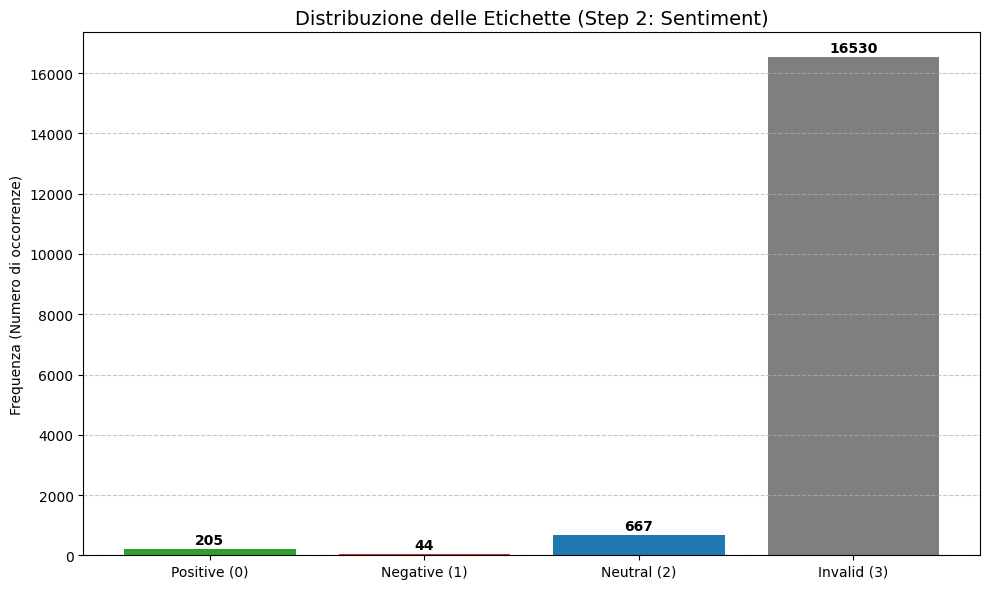

In [4]:
import matplotlib.pyplot as plt
url = "data_coppie/test_restaurant_pairs.pkl"
df = pd.read_pickle(url)
df.sample(5)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# 1. Estraiamo tutti i singoli valori dalle liste della colonna 'labels'
all_labels = []
for row in df['labels']:
    # Se i dati sono stringhe, usiamo ast.literal_eval per convertirli in liste
    if isinstance(row, str):
        l = ast.literal_eval(row)
    else:
        l = row
    all_labels.extend(l)

# 2. Contiamo le occorrenze di ogni classe
unique, counts = np.unique(all_labels, return_counts=True)
label_map = {0: 'Positive (0)', 1: 'Negative (1)', 2: 'Neutral (2)', 3: 'Invalid (3)'}
names = [label_map.get(x, f"Classe {x}") for x in unique]

# 3. Creazione del Grafico
plt.figure(figsize=(10, 6))
colors = ['#2ca02c', '#d62728', '#1f77b4', '#7f7f7f'] # Verde, Rosso, Blu, Grigio
bars = plt.bar(names, counts, color=colors[:len(names)])

# Aggiungiamo i valori numerici sopra ogni barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(counts)*0.01), 
             int(yval), ha='center', fontweight='bold')

plt.title('Distribuzione delle Etichette (Step 2: Sentiment)', fontsize=14)
plt.ylabel('Frequenza (Numero di occorrenze)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()